In [2]:
import pandas as pd
import numpy as np
import statsmodels
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_recall_curve, auc, f1_score, accuracy_score, roc_auc_score, roc_curve, recall_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [3]:
import scipy.stats as ss

import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

def cramers_corrected(x, y):
    """Calculate Cramers V statistic for categorical-categorical association.
    Uses correction from Bergsma and Wicher, Journal of the Korean Statistical Society 42 (2013): 323-328"""
    result = -1
    if len(x.value_counts()) == 1:
        print("First variable is constant")
    elif len(y.value_counts()) == 1:
        print("Second variable is constant")
    else:
        conf_matrix = pd.crosstab(x, y)

        if conf_matrix.shape[0] == 2:
            correct = False
        else:
            correct = True

        chi2 = chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2 / n
        r, k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
        rcorr = r - ((r - 1) ** 2) / (n - 1)
        kcorr = k - ((k - 1) ** 2) / (n - 1)
        result = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
    return round(result, 6)

def cramers_v_matrix(df):
    cols = df.columns
    n = len(cols)
    result = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                result[i, j] = 1.0
            else:
                confusion_matrix = pd.crosstab(df.iloc[:, i], df.iloc[:, j])
                result[i, j] = cramers_corrected(df.iloc[:, i], df.iloc[:, j])
    return pd.DataFrame(result, index=cols, columns=cols)

# Example usage:
# df = pd.read_csv('your_data.csv')
# cramers_v_matrix(df)



def plot_mosaic_plots(mod, target):
    variables = mod.drop(target, axis=1).columns.tolist()

    # Determine the target classes
    target_classes = mod[target].unique()

    if len(target_classes) != 2:
        raise ValueError("The target variable should have exactly 2 unique classes.")

    # Color mapping based on the target class order
    color_map = {
        target_classes[0]: '#22577A',
        target_classes[1]: '#FB3640'
    }

    for variable in variables:
        # Create a crosstab (contingency table) for each variable against the target
        table = pd.crosstab(mod[variable], mod[target])

        # Define the properties function as a lambda functio
        props = lambda key: {'color': color_map[int(key[1])]}

        print(f"Mosaic plot for {variable} vs {target}:\n")

        # Create mosaic plot with the properties lambda function
        mosaic(table.stack(), title=f"Mosaic Plot for {variable} vs {target}", properties=props)
        plt.show()
        print("-" * 50)


# Definición de la función para evaluar los distintos modelos elegidos
def model_evaluation(models, scores, X, y, splits, seed):
    results = []
    
    # Para cada modelo
    for name, model in models:
        warnings.filterwarnings('ignore')
        # KFold
        KF = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)

        # Cross_val
        cv_results = cross_validate(model, X, y, cv=KF, scoring=scores, verbose=False)

        # Store results for each fold and each metric
        for fold in range(splits):
            result = {"Model": name, "Fold": fold + 1}
            for score in scores:
                result[score] = cv_results[f"test_{score}"][fold]
            results.append(result)

        # Print results numerically
        print(f'--\n{name} model:')
        for key in scores:
            print("%s: mean %f, std (%f) " % (key, cv_results[f"test_{key}"].mean(), cv_results[f"test_{key}"].std()))

    # Convert results to DataFrame
    return pd.DataFrame(results)

def plot_ROC_PR_curve(y_test,y_proba, title):
    # Calculate ROC curve and ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Calculate Precision-Recall curve and AUC
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)

    # Plot ROC curve
    plt.figure(figsize=(12, 5))
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')

    # Plot Precision-Recall curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', label=f'PR curve (area = {pr_auc:.4f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall (PR) Curve')
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

# Function to calculate accuracy at different thresholds
def find_best_threshold(y_true, y_proba,metric):
    thresholds = np.linspace(0, 1, 100)
    scores = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        score = metric(y_true, y_pred)
        scores.append(score)
    best_threshold = thresholds[np.argmax(scores)]
    best_accuracy = max(scores)

    return best_threshold, best_accuracy

## 0. Information about the dataset
This dataset is used to perform discrimination of benign and malignant mammographic masses based on BI-RADS attributes and the patient's age. 
It contains a BI-RADS assessment, the patient's age and three BI-RADS attributes together with the ground truth (the severity field) for 516 benign and 445 malignant masses that have been identified on full field digital mammograms collected at the Institute of Radiology of the University Erlangen-Nuremberg between 2003 and 2006.

Class Distribution: benign: 516; malignant: 445.

-- 

Information about the variables:
1. BI-RADS assessment: 1 to 5 (ordinal, non-predictive!)  
2. Age: patient's age in years (integer)
3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
6. Severity: benign=0 or malignant=1 (binominal, goal field!)

## 1. Data import

In [4]:
dataset = pd.read_csv(r"mammographic_masses.csv", header=None)
print(f"The dataset is comprised of {dataset.shape[0]} rows and {dataset.shape[1]} columns")
rename_dict = {0: "BI-RADS", 1: "Age", 2: "Shape", 3: "Margin", 4: "Density", 5: "Severity"}
dataset.rename(columns=rename_dict, inplace=True)
dataset = dataset.drop("BI-RADS",axis=1) # Drop non predictive BI-RADS column
dataset.head()

The dataset is comprised of 961 rows and 6 columns


,Age,Shape,Margin,Density,Severity
0,67,3,5,3,1
1,43,1,1,?,1
2,58,4,5,3,1
3,28,1,1,3,0
4,74,1,5,?,1


## 1. Preliminary analysis & data cleaning

### 1.1 Data types

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Age       961 non-null    object
 1   Shape     961 non-null    object
 2   Margin    961 non-null    object
 3   Density   961 non-null    object
 4   Severity  961 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 37.7+ KB


Checking the data types, it becomes obvious that the 'object' type columns where the data is inherently numeric are due to non-numeric characters that have been inserted in them, probably to encode missing values. Therefore, before correcting these data types, incorrect encodings must be handled.

### 1.1.1 Incorrect encoding handling

In [6]:
for column in dataset.columns:
    display(dataset[column].value_counts(dropna=False))

Age
59    36
67    32
57    32
66    31
46    28
      ..
18     1
82     1
93     1
96     1
20     1
Name: count, Length: 74, dtype: int64

Shape
4    400
1    224
2    211
3     95
?     31
Name: count, dtype: int64

Margin
1    357
4    280
5    136
3    116
?     48
2     24
Name: count, dtype: int64

Density
3    798
?     76
2     59
1     16
4     12
Name: count, dtype: int64

Severity
0    516
1    445
Name: count, dtype: int64

It seems NaN values have been encoded as a '?' character, therefore we can correct them by:
- replacing this caracter for an np.nan()
- converting to numeric and coercing errors to NaN

However, these columns, appart from age, are categorical of nominal and ordinal type, and hold a very small number of unique values. Therefore, it will be worth converting them to 'category' and treating them as such.

In [7]:
dataset = dataset.apply(lambda x: pd.to_numeric(x,errors='coerce'))

### 1.2 Explore unique values and missing data

Checking data types again, we can now see that not all rows have non-null values and that the correct data types are now present. These NaN values will have to be properly handled later on.

In [8]:
(dataset.info())
dataset.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       956 non-null    float64
 1   Shape     930 non-null    float64
 2   Margin    913 non-null    float64
 3   Density   885 non-null    float64
 4   Severity  961 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 37.7 KB


Age          5
Shape       31
Margin      48
Density     76
Severity     0
dtype: int64

In [9]:
dataset.describe()

,Age,Shape,Margin,Density,Severity
count,956.000000,930.000000,913.000000,885.000000,961.000000
mean,55.487448,2.721505,2.796276,2.910734,0.463059
std,14.480131,1.242792,1.566546,0.380444,0.498893
min,18.000000,1.000000,1.000000,1.000000,0.000000
25%,45.000000,2.000000,1.000000,3.000000,0.000000
50%,57.000000,3.000000,3.000000,3.000000,0.000000
75%,66.000000,4.000000,4.000000,3.000000,1.000000
max,96.000000,4.000000,5.000000,4.000000,1.000000


The only remaining numeric feature is 'Age', which according to the descriptive summary does not show any out of range numbers.

### 2. EDA

### 2.1 Univariate analysis

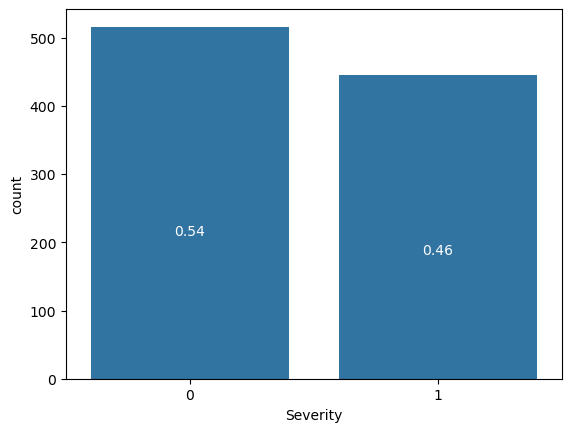

In [10]:
fig, ax1 = plt.subplots()

sns.countplot(data=dataset,x="Severity",ax=ax1)
for bar in ax1.patches:
    height = bar.get_height()
    x_position = bar.get_x() + bar.get_width() / 2
    ax1.text(x_position, height/2 - height/2*0.2, round(height/dataset.shape[0],2), ha='center', va='bottom', color='white')

From the figure above we can see there is a slight imbalance of the target feature.

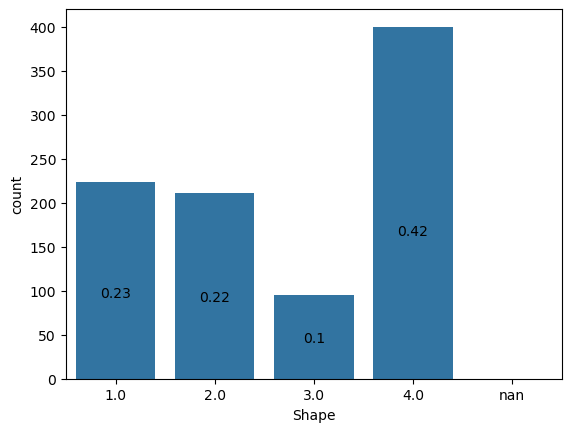

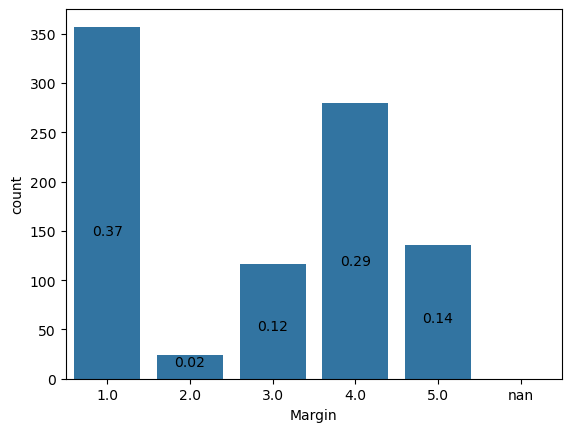

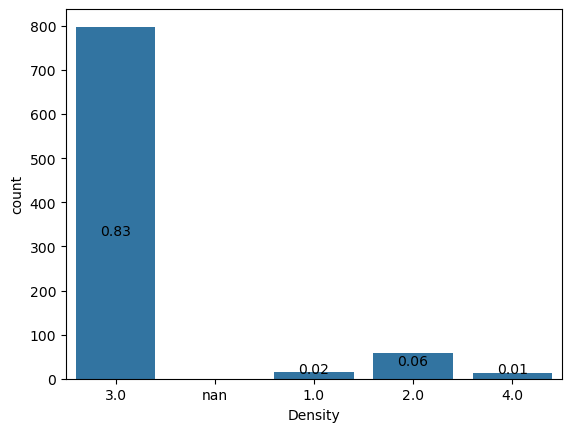

In [11]:
for column in ["Shape","Margin","Density"]:
    fig, ax1 = plt.subplots()

    sns.countplot(data=dataset,x=column,ax=ax1,order=sorted(dataset[column].unique()))
    for bar in ax1.patches:
        height = bar.get_height()
        x_position = bar.get_x() + bar.get_width() / 2
        ax1.text(x_position, height/2 - height/2*0.2, round(height/dataset.shape[0],2), ha='center', va='bottom', color='black')

3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
6. Severity: benign=0 or malignant=1 (binominal, goal field!)

The most prevalent mammographic mass shape is irregular, while the least is lobular. 

The most frequent values for the mass margin are microlobulated and ill-defined, the latter giving itself the sense of not positively contributing to a healthy mass. In this case, we find a feature that has a very small percentage of representation 2%, which makes up for 24 observations. That is problematic, as to achieve statistical significance a minimum of 20-30 observations is necessary and this will very easily not be achieved after CV partitions for instance, or tree-based methods.

Finally, for the density of the mass, the by far most frequent value is "low" density, with a 83% of observations holding this value. Given this high representation, intuition tells that there is small variance and thus influence with regards to the target will be low. Additionally, the 1 and 4 values hace extremely low representations, which will have to be handled.

<Axes: xlabel='Age', ylabel='Count'>

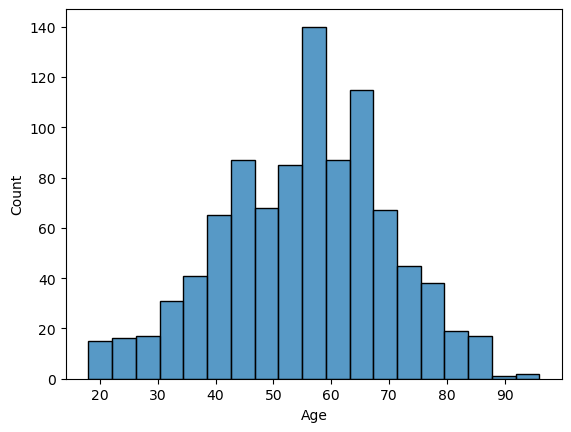

In [12]:
sns.histplot(data=dataset,x="Age")

As expected for a natural measure, age presents a very normal distribution, without any seeming outliers.

### 2.2 Feature relationships - Bivariate and multivariate analysis

,Age
Severity,
0,49.713178
1,62.259091


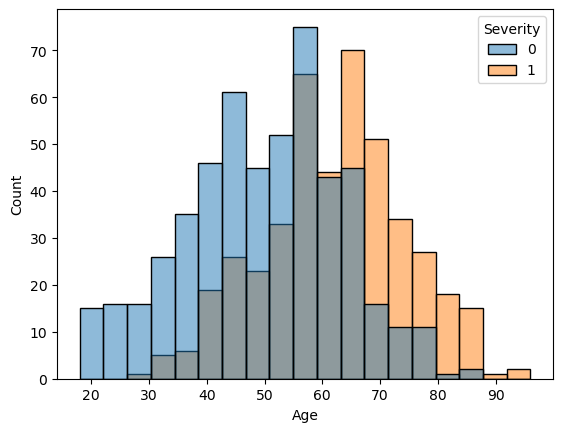

In [13]:
sns.histplot(data=dataset,x="Age",hue="Severity")

dataset.groupby("Severity").agg({"Age":"mean"})

The age distribution for both the severe assessed mammographic masses patients holds the same gaussian shaped distribution for the non-severe ones, but older. Women with severe mammographic masses are 12.5 years older on average.

Mosaic plot for Shape vs Severity:



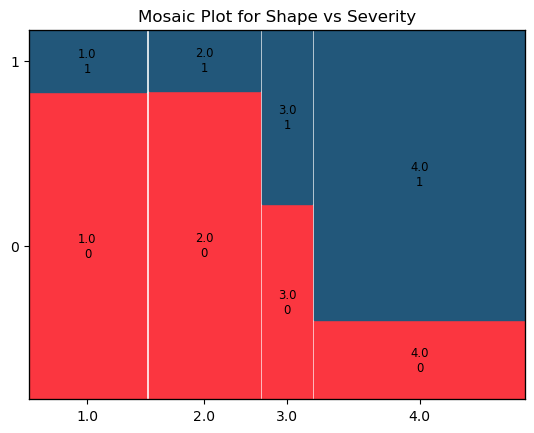

--------------------------------------------------
Mosaic plot for Margin vs Severity:



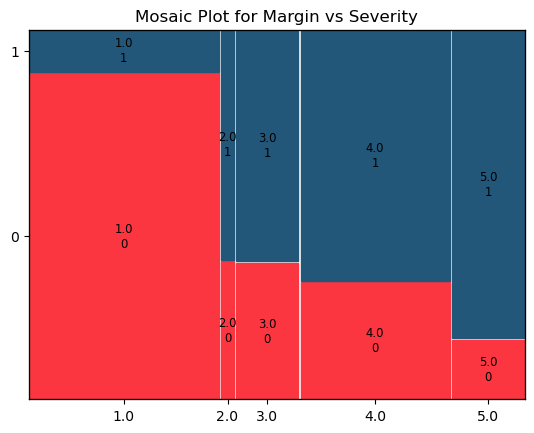

--------------------------------------------------
Mosaic plot for Density vs Severity:



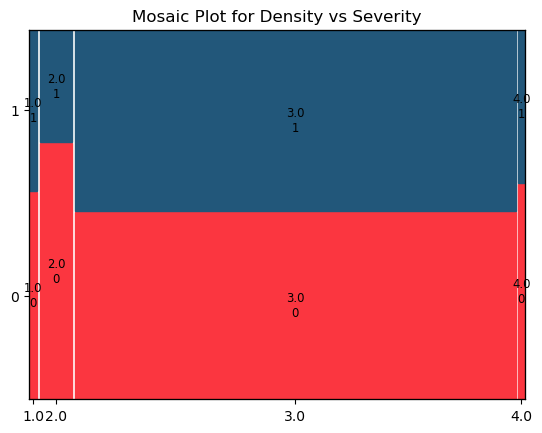

--------------------------------------------------


In [14]:
plot_mosaic_plots(dataset.drop("Age",axis=1),"Severity")

Regarding the variation of Shape, Margin and Density with regards to the target class:
- The Shape feature sees no variation for the first two categories of the predictor, but overall there is an important variation between categories that should allow to separate well based on them. The severity incidence increases as the value assigned to the supposedly nominal variable increases.
- Similarly, the margin feature exposes a higher severity as the category number increases, with a big jump from 1 to 2.
- Finally, the supossedly ordinal feature exposes the least ordinal behaviour of the three, being categories 1 and 3 the most severe associated and with clear variance with respect to 2 and 4. Categories 1 and 4 are hard to read due to the now visually obvious small representation.

Given that the target feature is binary, pearson's correlation cannot be used to assess feature relationship. Cramer's V coefficient can be used for these cases.

<Axes: >

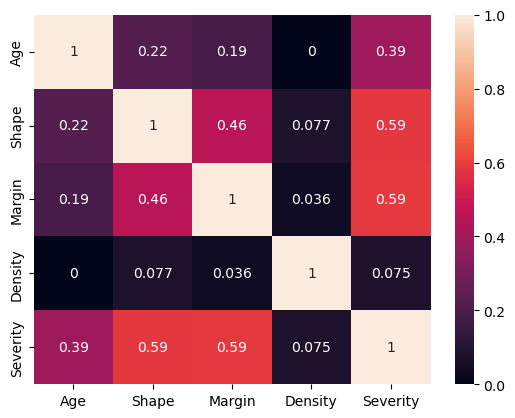

In [15]:
sns.heatmap(cramers_v_matrix(dataset),annot=True)

The low Cramer's V coefficient confirms the small differentiation presented between categories of the Density variable. On the other hand, both Margin and Shape bear a moderate correlation with Severity. Besides, these 2 features show a moderate correlation that should not pose "multicolinearity" problem.

### 3. Feature engineering and preparation for modeling



#### 3.1 Engineer new features

No new features are suggested for the time being, as the current domain expertise does not provide any quick proposals and there is no clear logic to create new features from the categorical at hand. This will be revisited, however, after a first modeling.



#### 3.2 Prepare data for modelling



##### 3.2.1 Outliers


Although the only numerical variable "Age",

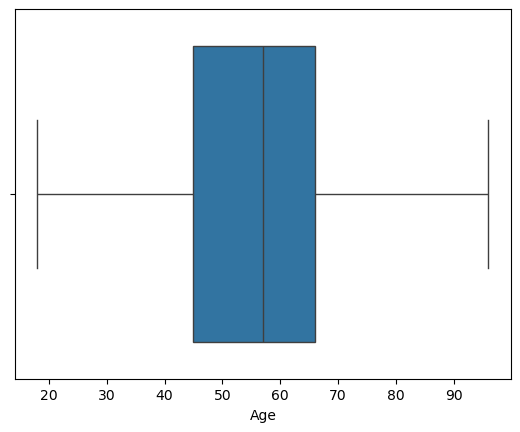

In [16]:
sns.boxplot(dataset,x="Age")
plt.show()

There are no outliers present in the only true numerical variable, which is age. Therefore, no treatmeant is needed. In case a treatment was needed, it should be done at pipeline level, to fit the outliers treatment at train level and only perform transformation at production level, where the scoring data will have been unseen.




##### 3.2.2 Missing data

The missing data found in the dataset must be imputed for certain algorithms to properly handle it, like logistic regression. For certain applications, creating proxies of an imputed column where rows of imputed values hold a value of 1 and non-imputed values hold a value of 0 can increase precision as it might identify a pattern within the missing data, and such approach can be used here.

- Missing data above 50%: Drop the column or the row.
- Missing data between 5% to 50%: If feature is categorical, recategorize to "Missing". If numerical, impute the value and create proxy variable with imputed value.
- Missing data between 0% and 5%: Impute.

Also, another column with information about the % of missing data can be created to see if there is an underlying pattern in the existence of missing data.

Missing data on rows:

In [17]:
## Missing_data_rows
missing_data_rows = dataset.isna().sum(axis=1)/dataset.drop("Severity",axis=1).shape[1]
display(missing_data_rows.value_counts())

dataset_2 = dataset.copy().assign(missing=missing_data_rows.astype("category"))

0.00    831
0.25    100
0.50     30
Name: count, dtype: int64

Missing data on columns:

In [18]:
dataset.isna().sum()/dataset.shape[0]

Age         0.005203
Shape       0.032258
Margin      0.049948
Density     0.079084
Severity    0.000000
dtype: float64

The count of missing data on rows can be used as a categorical feature of numeric values, that will be tested as a new dataset.

On the columns, although only the density column holds more than 5% of missing data, Margin can also have its values recategorized to "Missing". The Shape feature can be simply imputed by simple methods like the mode or more advanced like KNN.

#### 3.2.3 Regroup under-represented categories

Each category in a categorical feature should have a minimum of 2.5%-5% of representation.

- Margin: category 2 (microlobulated) is underrepresented  but can be regrouped with 3 (obscured), given that they show no variance between them and the severity of the 2 might be equivalent. 
- Density: categories 1 (high) and 4 (fat-containing) are underrepresented. Although this features are ordinally encoded and the source cites this feature as ordninal, fat-containing might not fall within this order and both category 1 and 2 could be regrouped together, as they show equal proportion of the positive class.

In [19]:
dataset["Margin"] = dataset["Margin"].fillna("Missing").apply(lambda x: np.where((x == 2.0) | (x == 3.0),"2_3",x)).str.replace(".0","").astype("category")
dataset["Density"] = dataset["Density"].fillna("Missing").apply(lambda x: np.where((x == 1.0) | (x == 4.0),"1_4",x)).str.replace(".0","").astype("category")
dataset["Density"].value_counts(normalize=True)

Density
3          0.830385
Missing    0.079084
2          0.061394
1_4        0.029136
Name: proportion, dtype: float64

Density 1_4 category does not achieve a 5% of representation, but it is at least more than 2.5% and within the 20-30 mimimum observations range. If after a first iteration this is seen as troublesome, further regrouping will be necessary.

Convert the nominal shape variable to category:

In [20]:
dataset["Shape"] = dataset["Shape"].astype("category")
dataset["Shape"].value_counts(dropna=False)

Shape
 4.0    400
 1.0    224
 2.0    211
 3.0     95
NaN      31
Name: count, dtype: int64

### 4. Modeling

#### 4.1 Train-test split

In [21]:
from sklearn.model_selection import train_test_split
seed = 99

There are 2 datasets to evaluate, the plain one and the one with the row's missing values frequency.

In [22]:
# Plain dataset 
X = dataset[["Age","Shape","Margin","Density"]]
y = dataset["Severity"]

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, random_state=seed)

# Missing rows dataset
X_2 = dataset_2[["Age","Shape","Margin","Density","missing"]]

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2,y,stratify=y, random_state=seed)


Additionally, a group of classifiers will also be evaluated via cross-validation to pick the most promising ones among them.

In [23]:
models = [
        ("Logistic",LogisticRegression(random_state=seed)),
        ("Logistic_lasso",LogisticRegression(random_state=seed,penalty='l1', solver='saga')),
        ("Logistic_ridge",LogisticRegression(random_state=seed,penalty='l2', solver='lbfgs')),
        ("RandomForest", RandomForestClassifier(random_state=seed)),
        ("SVC",SVC(probability=True)),
        ("GB",GradientBoostingClassifier()),
        ("XGB",XGBClassifier())

]

categorical_transformer = Pipeline([('imputer',SimpleImputer(strategy="most_frequent")),("encoder",OneHotEncoder())])
numerical_transformer = Pipeline([('imputer',SimpleImputer(strategy="median")),("scaler",StandardScaler())])

data_prep1 = ColumnTransformer(transformers=[
    ("numeric",numerical_transformer,["Age"]),
    ("categorical",categorical_transformer,["Shape","Margin","Density"]),
])

data_prep2 = ColumnTransformer(transformers=[
    ("numeric",numerical_transformer,["Age"]),
    ("categorical",categorical_transformer,["Shape","Margin","Density","missing"]),
])

pipelines_1 = []
for name, model in models:
    pipeline = make_pipeline(data_prep1, model)
    pipelines_1.append((name+"_1", pipeline))

pipelines_2 = []
for name, model in models:
    pipeline = make_pipeline(data_prep2, model)
    pipelines_2.append((name+"_2", pipeline))


The main metrics for evaluation will be the area under the ROC curve, the area under the PR curve and the f1 score.

In [24]:
def auc_pr_scorer(y_true, y_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    return auc(recall, precision)

pr_auc_scorer = make_scorer(auc_pr_scorer, response_method="predict_proba")

evaluation_scores = {'roc_auc_pr':pr_auc_scorer,'roc_auc':'roc_auc','f1':'f1'}
n_splits = 5

A function for integrated cross-validation for easy iteration over datasets and pipeline is defined as follows:

In [25]:
# Definición de la función para evaluar los distintos modelos elegidos
def model_evaluation(models, scores, X, y, splits, seed):
    results = []
    
    # Para cada modelo
    for name, model in models:
        warnings.filterwarnings('ignore')
        # KFold
        KF = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)

        # Cross_val
        cv_results = cross_validate(model, X, y, cv=KF, scoring=scores, verbose=False)

        # Store results for each fold and each metric
        for fold in range(splits):
            result = {"Model": name, "Fold": fold + 1}
            for score in scores:
                result[score] = cv_results[f"test_{score}"][fold]
            results.append(result)

        # Print results numerically
        print(f'--\n{name} model:')
        for key in scores:
            print("%s: mean %f, std (%f) " % (key, cv_results[f"test_{key}"].mean(), cv_results[f"test_{key}"].std()))

    # Convert results to DataFrame
    return pd.DataFrame(results)

Run the cross-validation storing the results inside dataframes to visually and numerically assess the results.

In [26]:
evaluation_plain = model_evaluation(pipelines_1, evaluation_scores,X_train,y_train,n_splits,seed).assign(dataset="plain")

evaluation_missing = model_evaluation(pipelines_2, evaluation_scores,X_train_2,y_train_2,n_splits,seed).assign(dataset="missing")

--
Logistic_1 model:
roc_auc_pr: mean 0.828733, std (0.030275) 
roc_auc: mean 0.864295, std (0.026883) 
f1: mean 0.793125, std (0.035279) 
--
Logistic_lasso_1 model:
roc_auc_pr: mean 0.830834, std (0.030869) 
roc_auc: mean 0.865614, std (0.026753) 
f1: mean 0.794611, std (0.028361) 
--
Logistic_ridge_1 model:
roc_auc_pr: mean 0.828733, std (0.030275) 
roc_auc: mean 0.864295, std (0.026883) 
f1: mean 0.793125, std (0.035279) 
--
RandomForest_1 model:
roc_auc_pr: mean 0.749037, std (0.033781) 
roc_auc: mean 0.798260, std (0.025716) 
f1: mean 0.727088, std (0.028605) 
--
SVC_1 model:
roc_auc_pr: mean 0.793579, std (0.045540) 
roc_auc: mean 0.838811, std (0.037827) 
f1: mean 0.798476, std (0.036294) 
--
GB_1 model:
roc_auc_pr: mean 0.812736, std (0.028929) 
roc_auc: mean 0.843215, std (0.024897) 
f1: mean 0.763243, std (0.037207) 
--
XGB_1 model:
roc_auc_pr: mean 0.758880, std (0.026900) 
roc_auc: mean 0.807391, std (0.026041) 
f1: mean 0.742623, std (0.039487) 
--
Logistic_2 model:
roc_au

,pr_auc_mean,pr_auc_std
dataset,,
missing,0.803947,0.045103
plain,0.800362,0.046422


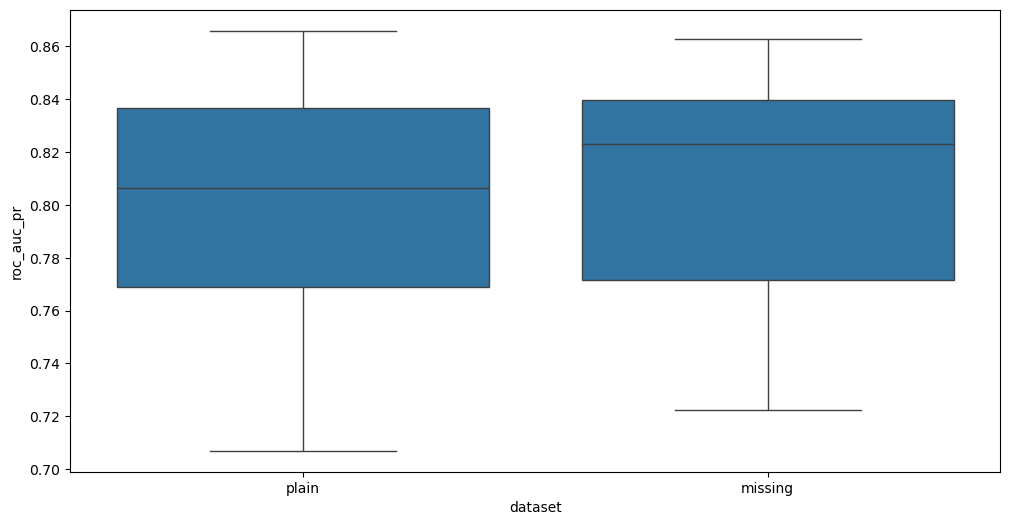

In [27]:
evaluation = pd.concat([evaluation_plain,evaluation_missing],axis=0)
fig = plt.figure(figsize=(12,6))
sns.boxplot(data=evaluation,x="dataset",y="roc_auc_pr")
evaluation.groupby("dataset").agg(pr_auc_mean=("roc_auc_pr","mean"),pr_auc_std=("roc_auc_pr","std"))

As seen above, the dataset with the missing proxy variables succeeds in capturing some hidden information in their gaps, scoring a higher PR_AUC with a smaller standard deviation. 

Similarly, from the plotted results below, the logistic regression, support vector regressor and gradient boosting are chosen to optimize their hyperparameters and cross-evaluate with the most optimal configuration.

,,pr_auc_mean,pr_auc_std
Model,dataset,,
GB_1,plain,0.812736,0.032344
GB_2,missing,0.809291,0.044405
Logistic_1,plain,0.828733,0.033849
Logistic_2,missing,0.828332,0.033017
Logistic_lasso_1,plain,0.830834,0.034512
Logistic_lasso_2,missing,0.829504,0.034126
Logistic_ridge_1,plain,0.828733,0.033849
Logistic_ridge_2,missing,0.828332,0.033017
RandomForest_1,plain,0.749037,0.037768


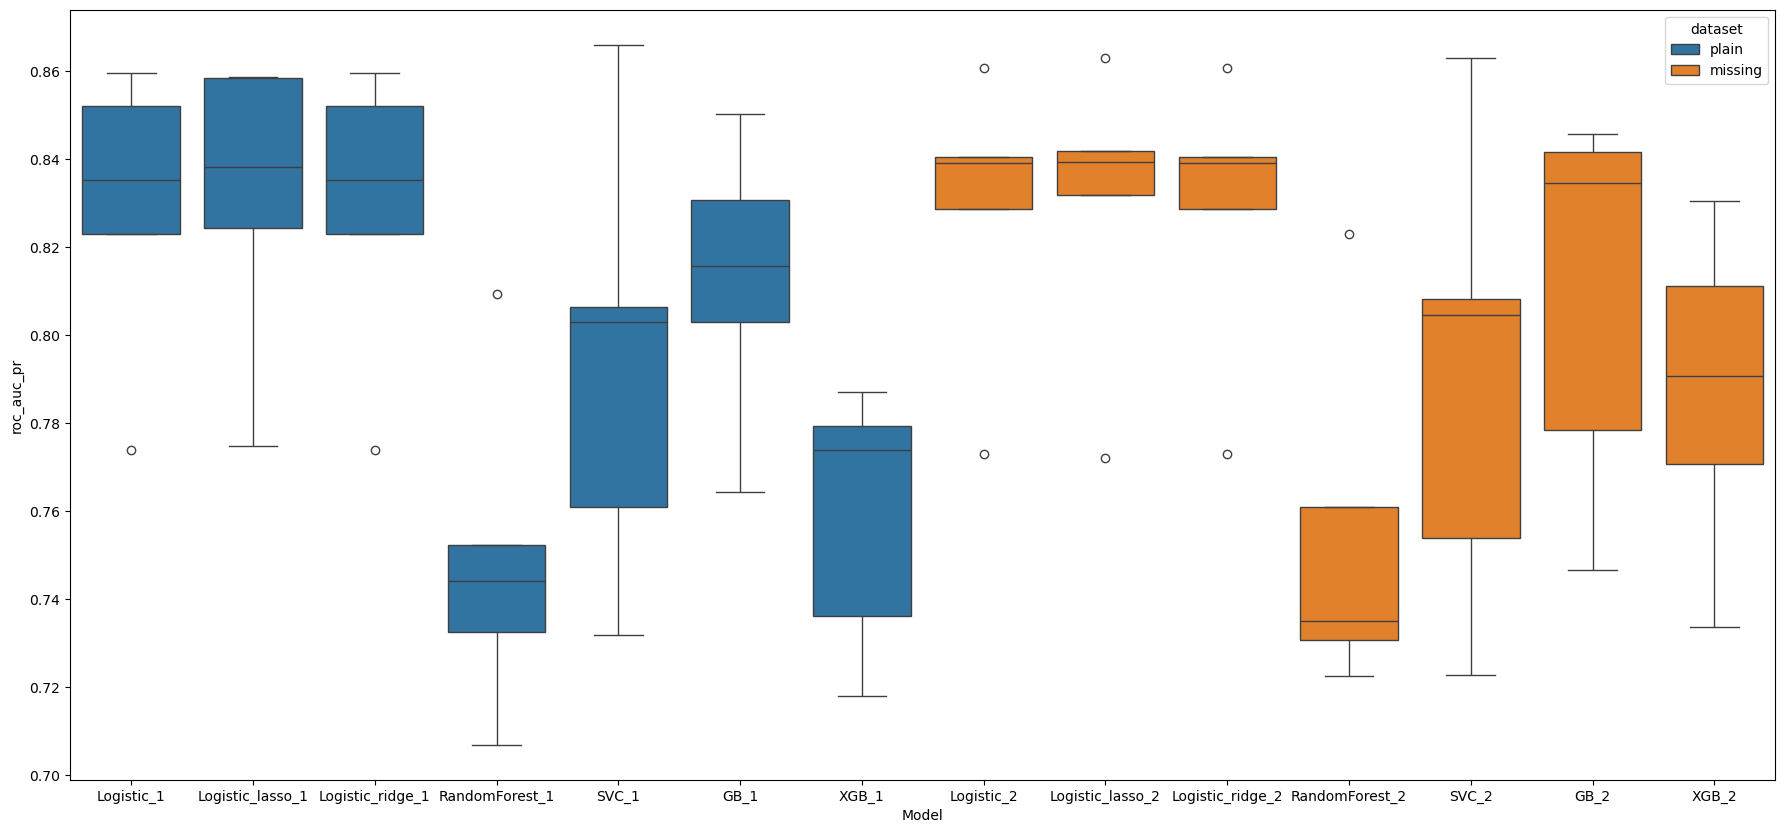

In [28]:
evaluation = pd.concat([evaluation_plain,evaluation_missing],axis=0)
fig = plt.figure(figsize=(22,10))
sns.boxplot(data=evaluation,x="Model",y="roc_auc_pr",hue="dataset")
evaluation.groupby(["Model","dataset"]).agg(pr_auc_mean=("roc_auc_pr","mean"),pr_auc_std=("roc_auc_pr","std"))

Grid Search hyperparameters optimization:

In [29]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 99)

In [30]:
svc = pipelines_1[4][1] # SVC

param_group_linear = {
    'svc__kernel': ['linear'],
    'svc__C': [0.1, 1, 10, 100]
}

param_group_poly = {
    'svc__kernel': ['poly'],
    'svc__C': [0.1, 1, 10, 100],
    'svc__degree': [2, 3, 4],
    'svc__coef0': [0, 0.1, 0.5, 1]
}

param_group_rbf_sigmoid = {
    'svc__kernel': ['rbf', 'sigmoid'],
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
}

param_grid_SVC = [param_group_linear, param_group_poly, param_group_rbf_sigmoid]

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid_SVC, n_jobs=-1, cv=cv, scoring="roc_auc")
grid_result = grid_search.fit(X_train_2, y_train_2)

print("Best AUC: %f , achivied using the parameters %s" % (grid_result.best_score_, grid_result.best_params_))

Best AUC: 0.868908 , achivied using the parameters {'svc__C': 1, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [31]:
log_reg = pipelines_1[0][1] # Linear regression

param_group_l1_l2 = {
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__solver': ['liblinear', 'saga']
}

param_group_elasticnet = {
    'logisticregression__penalty': ['elasticnet'],
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__solver': ['saga'],
    'logisticregression__l1_ratio': [0, 0.5, 1]
}

param_group_classic = {
    'logisticregression__penalty': ['none'],
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__solver': ['liblinear', 'saga']
}

# Combine groups into a list of parameter dictionaries
param_grid_logistic = [param_group_l1_l2, param_group_elasticnet, param_group_classic]


grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid_logistic, n_jobs=-1, cv=cv, scoring="roc_auc")
grid_result = grid_search.fit(X_train_2, y_train_2)

print("Best AUC: %f , achivied using the parameters %s" % (grid_result.best_score_, grid_result.best_params_))

Best AUC: 0.871176 , achivied using the parameters {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}


In [32]:
gbclass = pipelines_1[5][1] # Gradient Boosting classifier

# Define your parameter groups
param_group_base = {
    'gradientboostingclassifier__n_estimators': [50, 100, 200],
    'gradientboostingclassifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'gradientboostingclassifier__max_depth': [3, 4, 5, 6]
}

param_group_min_samples = {
    'gradientboostingclassifier__min_samples_split': [2, 5, 10],
    'gradientboostingclassifier__min_samples_leaf': [1, 2, 4]
}

param_group_subsample_features = {
    'gradientboostingclassifier__subsample': [0.8, 0.9, 1.0],
    'gradientboostingclassifier__max_features': ['auto', 'sqrt', 'log2', None]
}

# Combine groups into a list of parameter dictionaries
param_grid_gb = [param_group_base, param_group_min_samples, param_group_subsample_features]

grid_search = GridSearchCV(estimator=gbclass, param_grid=param_grid_gb, n_jobs=-1, cv=cv, scoring="roc_auc")
grid_result = grid_search.fit(X_train_2, y_train_2)

print("Best AUC: %f , achivied using the parameters %s" % (grid_result.best_score_, grid_result.best_params_))

Best AUC: 0.868314 , achivied using the parameters {'gradientboostingclassifier__learning_rate': 0.01, 'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__n_estimators': 200}


In [33]:
svc= make_pipeline(data_prep2, SVC(C=1, kernel="rbf", gamma = 0.001,probability=True))
svc.fit(X_train_2, y_train_2)

gb= make_pipeline(data_prep2, GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators= 200))
gb.fit(X_train_2, y_train_2)

lr= make_pipeline(data_prep2, LogisticRegression(C=0.1, penalty='l1',solver='liblinear'))
lr.fit(X_train_2, y_train_2)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Shape', 'Margin', 'Density',
                                                   'missing'])])),
                ('logisticregression',
                 LogisticRegression(C=0.1, penalty='l1', solver='liblinear'))])

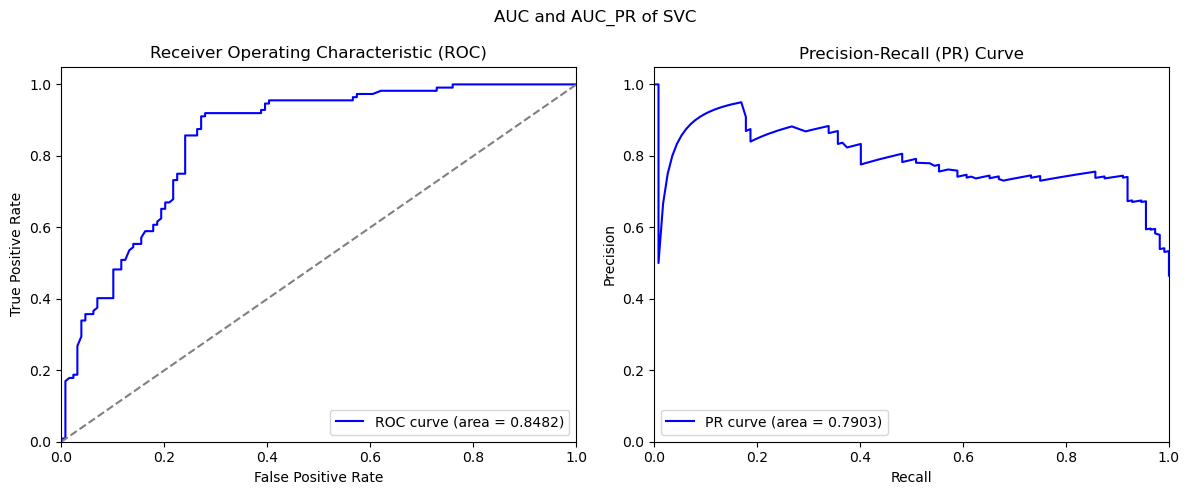

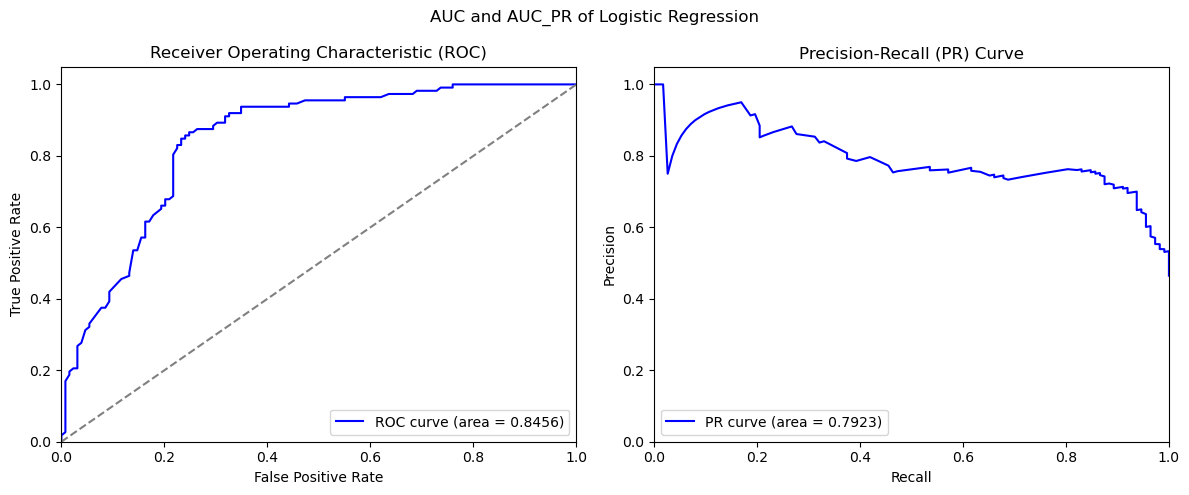

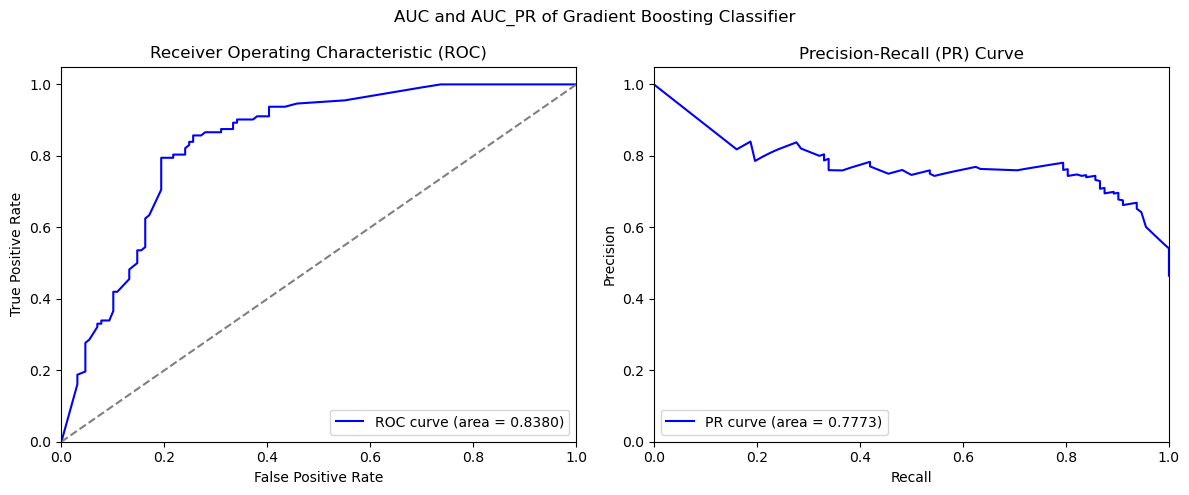

In [34]:
y_proba_svc = svc.predict_proba(X_test_2)[:, 1]
y_proba_lr = lr.predict_proba(X_test_2)[:, 1]
y_proba_gb = gb.predict_proba(X_test_2)[:, 1]

plot_ROC_PR_curve(y_test_2,y_proba_svc,"AUC and AUC_PR of SVC")
plot_ROC_PR_curve(y_test_2,y_proba_lr, "AUC and AUC_PR of Logistic Regression")
plot_ROC_PR_curve(y_test_2,y_proba_gb, "AUC and AUC_PR of Gradient Boosting Classifier")

Analyzing the area under the ROC and PR curves of the most optimal configuration for the chosen models, the difference between SVC and Logistic Regression is very small. There area under the ROC curve is superior for the SVC but it is the opposite for the PR curve. Given that the Logistic Regression is a very transparent algorithm in terms of interpretability and that for these health diagnostic cases we want to maximize recall to diagnose all or almost all patients that DO have the disease, while keeping costs and patience inconvenience of additional medical tests, Logistic Regression is favoured.

In that case, the classification can be set to 0.2 in order to predict as positive the 95% of real positives, at the expense of a 36% of false positive predictions:

              precision    recall  f1-score   support

           0       0.92      0.54      0.68       129
           1       0.64      0.95      0.77       112

    accuracy                           0.73       241
   macro avg       0.78      0.74      0.72       241
weighted avg       0.79      0.73      0.72       241



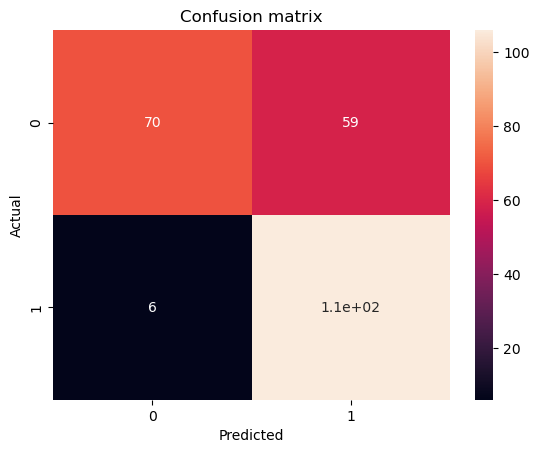

In [40]:
y_pred_lr = (y_proba_lr > 0.2).astype(int)
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test_2,y_pred_lr),annot=True)
ax.set_title("Confusion matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
print(classification_report(y_test_2,y_pred_lr))

The chosen linear regression model performs l1 Lasso regularization on the features log-loss cost function. This in practice can perform automatic feature selection that could further be commented and iterated on, but for short discussion purposes, let's inspect what feature weights it assigned.

In [47]:
logistic_regression_model = lr.named_steps['logisticregression']

column_transformer = lr.named_steps['columntransformer']

numeric_features = column_transformer.transformers_[0][2]
categorical_features = column_transformer.transformers_[1][2]

ohe = column_transformer.transformers_[1][1].named_steps['encoder']
categorical_feature_names = ohe.get_feature_names_out(categorical_features)

feature_names = list(numeric_features) + list(categorical_feature_names)

coefficients = logistic_regression_model.coef_[0]
intercept = logistic_regression_model.intercept_[0]

feature_coefficients = dict(zip(feature_names, coefficients))

print(f"Intercept: {intercept}")
# Print the feature coefficients
for feature, coefficient in feature_coefficients.items():
    print(f"{feature}: {coefficient}")

Intercept: 0.0
Age: 0.7315745251669815
Shape_1.0: 0.0
Shape_2.0: -0.03518056041804808
Shape_3.0: 0.0
Shape_4.0: 0.8738203279430653
Margin_1.0: -1.528608541592087
Margin_2.0: 0.0
Margin_3.0: 0.0
Margin_4.0: 0.0
Margin_5.0: 0.0
Density_1.0: 0.0
Density_2.0: 0.0
Density_3.0: 0.0
Density_4.0: 0.0
missing_0.0: 0.0
missing_0.25: 0.0
missing_0.5: 0.0


As stated above, the lasso penalized all weights it did not deem important, including the intercept. As such, it found _Age_ to be the most the most relevant continious feature, being _Shape = irregular_ (value 4.0) a very severe indicator thatdrives up the probability of the mass being unhealthy and a _Margin = circumscribed_ a strong indicator of a healthy mass. Additionally it found _Shape_ of value 2 to be a slight indicator of a healhy mass, but value 1 was equally healthy according to the event ratio of severtiy. Therefore, here are seen the possible limitations in the simplifications of the model, that in any case is the best predictor of severity for the time being.

Finally, the chosen model pipeline can be stored as a pickle file to be integrated in a scoring script for production:

In [62]:
import joblib

joblib.dump(lr, "mammographic_logistic_reg_classification.pkl")

['mammographic_logistic_reg_classification.pkl']